## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from cleanplots import *
import numpy as np
import os
import sys
sys.path.append("../../") # needed to bring in sdc module
from ReconCode import sdc_jax as sdc
import jax.numpy as jnp
import jax
from figures_util import *
from cleanplots import *
import yaml
import csv
from scipy.signal import savgol_filter
from skimage import io
import scipy.ndimage as ndimage
import matplotlib.patches as patches
import pandas as pd


# stop jax from taking over gpu memory
gpu = 0
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false'
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

def load_spectrum(filepath, start_row=32):
    """Load wavelength and intensity from a CSV file."""
    wavelengths, intensities = [], []
    with open(filepath, 'r') as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        for row in list(csvreader)[start_row:-1]:  # Skip initial rows if needed
            vals = row[0].split(';')
            wavelengths.append(float(vals[0]))
            intensities.append(float(vals[1]))
    return np.array(wavelengths), np.array(intensities)

def process_spectrum(wavelengths, intensities, wvmin, wvmax, filter_window=91, poly_order=3):
    """Cut spectrum to a wavelength range, apply Savitzky-Golay filter, and normalize."""
    idxmin = np.abs(wavelengths - wvmin).argmin()
    idxmax = np.abs(wavelengths - wvmax).argmin()

    cut_wavelengths = wavelengths[idxmin:idxmax]
    cut_intensities = intensities[idxmin:idxmax]
    filtered_intensities = savgol_filter(cut_intensities, filter_window, poly_order)
    normalized_intensities = filtered_intensities / np.max(filtered_intensities)
    
    return cut_wavelengths, normalized_intensities

def drawscalebar(ax, scalebarval, pxlsize, mag=1, loc='upper right', relative_height=0.05, offset_x_fraction=0.1, offset_y_fraction=0.1):
    scalebarsize = scalebarval * mag  # micron
    scalepix = int(scalebarsize / pxlsize)
    
    # Get the height and width directly from the image data
    image_height = ax.get_images()[0].get_array().shape[0]
    image_width = ax.get_images()[0].get_array().shape[1]
    
    # Calculate offsets in pixels from the center of the bar
    offset_x = image_width * offset_x_fraction
    offset_y = image_height * offset_y_fraction
    
    # Set the base center location based on loc
    if loc == 'upper right':
        center_x, center_y = image_width - offset_x, offset_y
    elif loc == 'upper left':
        center_x, center_y = offset_x, offset_y
    elif loc == 'lower right':
        center_x, center_y = image_width - offset_x, image_height - offset_y
    elif loc == 'lower left':
        center_x, center_y = offset_x, image_height - offset_y
    
    # Adjust x, y to be the bottom-left corner of the rectangle based on its center
    x = center_x - scalepix / 2
    y = center_y - (image_height * relative_height) / 2
    
    # Draw the scale bar as a rectangle
    rect = patches.Rectangle((x, y), scalepix, image_height * relative_height,
                             linewidth=1, edgecolor='white', facecolor='white')
    ax.add_patch(rect)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define some parameters and import the rest from the config file

In [33]:
# load config file
config_path = '/home/emarkley/Workspace/PYTHON/spectraldiffuserscope/ReconCode/Config_Files/huvec_celltrackergreenorangered_10x_paper.yaml'
figure_path = '/home/emarkley/Workspace/PYTHON/spectraldiffuserscope/PlottingCode/Figure_Notebooks/FigureFiles/fig_7b'
# make the folder if it doesn't exist
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
gamma = 1.6
objective = 10 # 10x objective
mag_size = objective*9/39 # 4x followed by diffuser F=9mm and relay lens f=39mm
spectral_camera_pixel_size = 2.4 # um
gt_pixel_size = 4.4 # um # empirically calculated based on 10 micron bead image
gt_mag_size = objective*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um

with open(config_path, 'r') as file:
    config_params = yaml.safe_load(file)

calibration_wavelengths_file = config_params['calibration']['calibration_wavelengths_file']
filter_cube_file = config_params['calibration']['filter_cube_file']
folder_location = config_params['calibration']['folder_location']
psf_name = config_params['calibration']['psf_name']

datafolder = config_params['data']['datafolder']
sample = config_params['data']['sample']

bits = config_params['measurement_processing']['bits']
crop_indices = config_params['measurement_processing']['crop_indices']
downsample_factor = config_params['measurement_processing']['downsample_factor']
wvmax = config_params['measurement_processing']['wvmax']
wvmin = config_params['measurement_processing']['wvmin']
wvstep = config_params['measurement_processing']['wvstep']

kmax = config_params['reconstruction']['kmax']
lamtv = config_params['reconstruction']['lamtv']
rank = config_params['reconstruction']['rank']
step_size = config_params['reconstruction']['step_size']
thr = config_params['reconstruction']['thr']
use_low_rank = config_params['reconstruction']['use_low_rank']
use_one_hot = config_params['reconstruction']['use_one_hot']
xytv = config_params['reconstruction']['xytv']

kprint = config_params['wandb']['kprint']
project_name = config_params['wandb']['project_name']
run_name = config_params['wandb']['run_name']
save_frequency = config_params['wandb']['save_frequency']
save_location = config_params['wandb']['save_location']


recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)


# Load the recon and generate the false color representation

In [34]:
# look for the file in the save location that contains the run name
files = os.listdir(save_location)
count = 0
target_files = []
for file in files:
    if run_name in file:
        target_files.append(os.path.join(save_location, file))
        count +=1

# if there are multiple files, print the number of files and the files themselves
if count > 1:
    print("Multiple files found with the same run name. Printing the files themselves:")
    for file in target_files:
        print(file)
else:
    print("Target file:", target_files[0])
    target_file = target_files[0]

# load the target file
data = np.load(target_file, allow_pickle=True)
xk = data['xk']
xk = jnp.array(xk)/jnp.max(xk)
U = data['U']
V = data['V']
weights = data['weights']
temperature = data['temperature']
# create false color image
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc.HSI2RGB_jax(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
false_color = np.array(false_color)


Target file: /home/emarkley/Workspace/PYTHON/spectraldiffuserscope/Results/huvec_celltrackergreenorangered_10x_paper_39vo4pxn.pkl


# Display an example of the recon

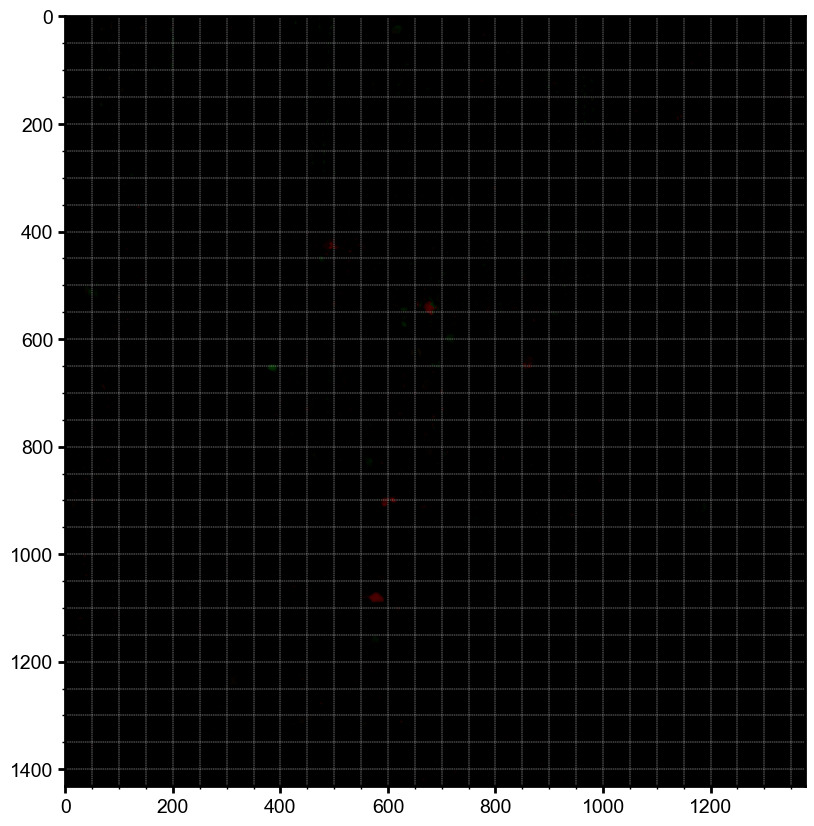

In [35]:
# show a smaller version of the false color image
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(false_color**gamma)
ax.set_xticks(np.arange(0, false_color.shape[1], 50), minor=True)
ax.set_yticks(np.arange(0, false_color.shape[0], 50), minor=True)
ax.grid(True, which='both', color='white', linestyle='--', linewidth=0.3)
plt.show()

# Define the bounds of the ROI and display

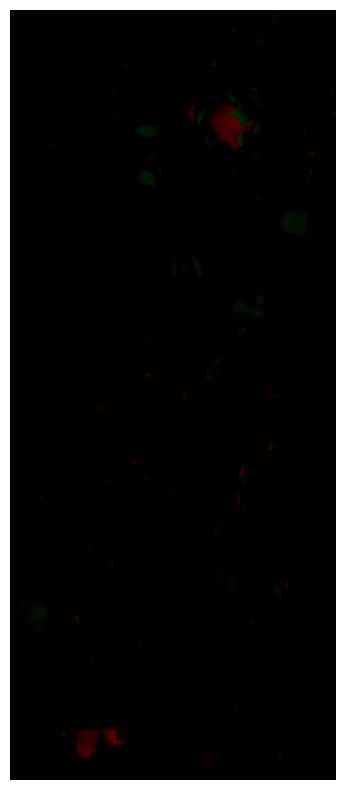

In [36]:
# define the bounds of the ROI
xlimits = [550,740]
ylimits = [475,925]
# define the false color inset

false_color_inset = false_color[ylimits[0]:ylimits[1], xlimits[0]:xlimits[1], :]

# display the false color inset
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(false_color_inset**gamma)
plt.axis('off')
plt.show()


## Load and plot the ground truth

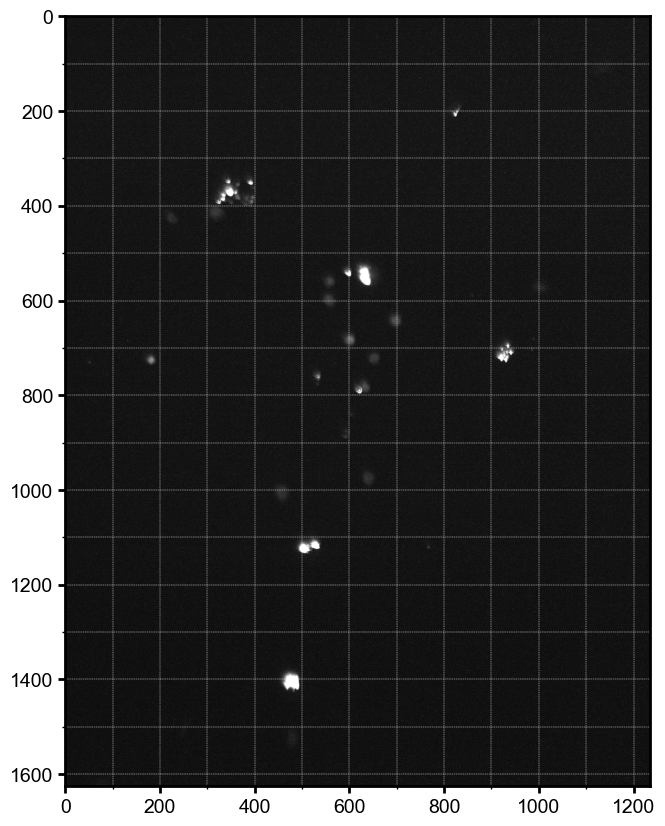

In [37]:
gt_name = 'gt.tiff'
gt = io.imread(os.path.join(datafolder, gt_name))/2**bits
gt = gt/np.max(gt)

gt_rot = gt

# rotate the image by -90 degrees
gt_rot = ndimage.rotate(gt, -90, reshape=True)
# gt_rot = gt_rot[800:3600,500:3300,:]

fig,ax = plt.subplots(figsize = (10,10))
plt.imshow(gt_rot,cmap='gray')
# add a finer grid to the image
ax.set_xticks(np.arange(0, gt_rot.shape[1], 100), minor=True)
ax.set_yticks(np.arange(0, gt_rot.shape[0], 100), minor=True)
ax.grid(True, which='both', color='white', linestyle='--', linewidth=0.3)
plt.show()
# get the inset



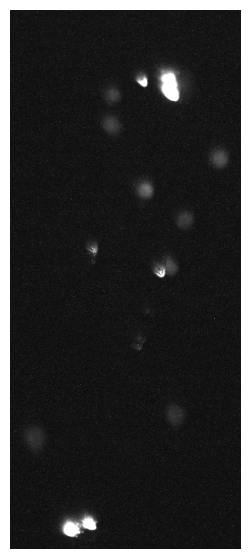

In [38]:
# define the bounds of the inset
xlimits = [425,725]
ylimits = [450,1150]

# get the inset
gt_inset = gt_rot[ylimits[0]:ylimits[1], xlimits[0]:xlimits[1]]

# display the inset
fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_inset, cmap = 'gray')
plt.axis('off')
plt.show()

# Plot the false color images with scale bars to make sure they look good

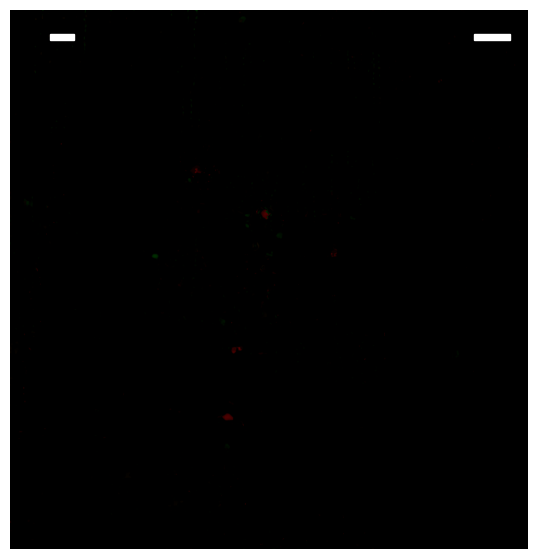

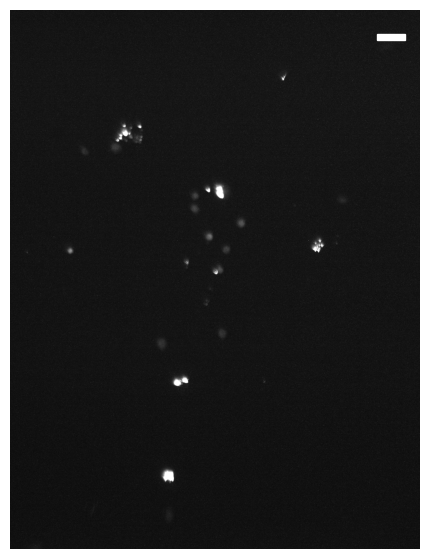

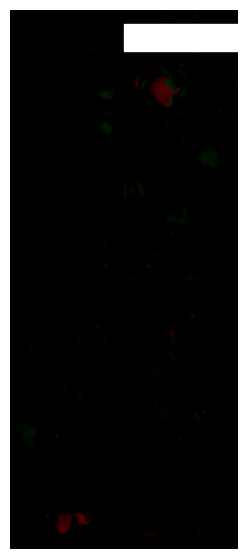

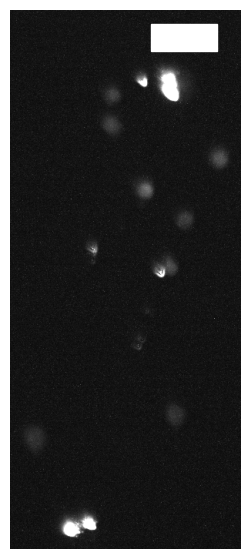

In [39]:
# Calculate aspect ratio based on image dimensions
false_color_aspect = false_color.shape[1] / false_color.shape[0]  # width/height
gt_aspect = gt_rot.shape[1] / gt_rot.shape[0]  # width/height

# Base figure height
height = 7

# Display and save false color full image
fig, ax = plt.subplots(figsize=(height*false_color_aspect, height))
plt.imshow(false_color**gamma)
plt.axis('off')
drawscalebar(ax, 100, recon_pixel_size, mag=mag_size, relative_height=0.01, offset_x_fraction=0.07, offset_y_fraction=0.05)
drawscalebar(ax, superpixel_size, spectral_camera_pixel_size, relative_height=0.01, loc='upper left', offset_x_fraction=0.1, offset_y_fraction=0.05)
plt.savefig(os.path.join(figure_path,'false_color_full_image.pdf'), dpi=300, bbox_inches='tight')
plt.show()

# Display and save ground truth full image
fig, ax = plt.subplots(figsize=(height*gt_aspect, height))
plt.imshow(gt_rot, cmap = 'gray')
plt.axis('off')
drawscalebar(ax, 100, gt_pixel_size, mag=gt_mag_size, relative_height=0.01, offset_x_fraction=0.07, offset_y_fraction=0.05)
plt.savefig(os.path.join(figure_path,'gt_full_image.pdf'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate aspect ratio based on image dimensions
false_color_aspect = false_color_inset.shape[1] / false_color_inset.shape[0]  # width/height
gt_aspect = gt_inset.shape[1] / gt_inset.shape[0]  # width/height

# Base figure height
height = 7

# Display and save false color inset
fig, ax = plt.subplots(figsize=(height*false_color_aspect, height))
plt.imshow(false_color_inset**gamma)
plt.axis('off')
drawscalebar(ax, 100, recon_pixel_size, mag=mag_size, relative_height=0.05, offset_x_fraction=0.25, offset_y_fraction=0.05)
plt.savefig(os.path.join(figure_path,'false_color_inset.pdf'), dpi=300, bbox_inches='tight')
plt.show()

# Display and save ground truth inset
fig, ax = plt.subplots(figsize=(height*gt_aspect, height))
plt.imshow(gt_inset, cmap = 'gray')
plt.axis('off')
drawscalebar(ax, 100, gt_pixel_size, mag=gt_mag_size, relative_height=0.05, offset_x_fraction=0.25, offset_y_fraction=0.05)
plt.savefig(os.path.join(figure_path,'gt_inset.pdf'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate aspect ratio based on image dimensions
false_color_aspect = false_color.shape[1] / false_color.shape[0]  # width/height
gt_aspect = gt_rot.shape[1] / gt_rot.shape[0]  # width/height

# Save the measurement

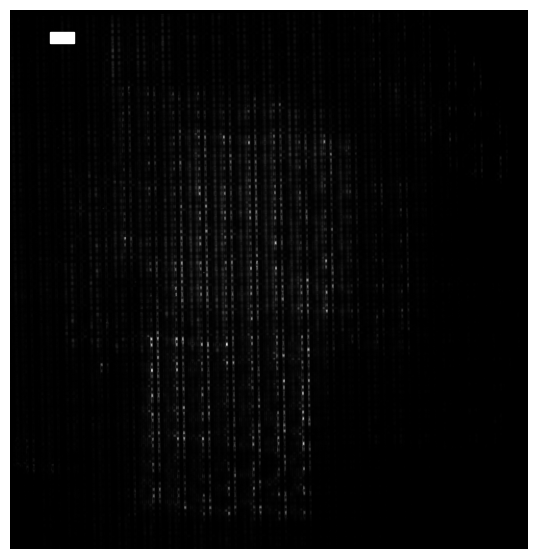

In [40]:
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'
bits = 16
power = 1

# load the tiff file natively
sample_meas = io.imread(os.path.join(datafolder, meas_name)) / 2**bits
# load the background tiff file natively
try:
    background = io.imread(os.path.join(datafolder, bg_name)) / 2**bits
except FileNotFoundError:
    print('No background image found, continuing without background subtraction')
    background = np.zeros(sample_meas.shape)

# crop the image
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

# Calculate aspect ratio based on image dimensions
measurement_aspect = measurement.shape[1] / measurement.shape[0]  # width/height

# Base figure height
height = 7

# Display and save measurement
fig, ax = plt.subplots(figsize=(height*measurement_aspect, height))
plt.imshow(measurement, cmap='gray')
plt.axis('off')
scalebar = drawscalebar(ax, superpixel_size, spectral_camera_pixel_size, relative_height=0.02, loc='upper left', offset_x_fraction=0.1, offset_y_fraction=0.05)
plt.savefig(os.path.join(figure_path, 'measurement.pdf'), dpi=300, bbox_inches='tight')
plt.show()


## Import ground truth spectra

CellTrackerGreenCMFDA.csv
CellTrackerOrangeCMRA.csv
Viafluor488.csv
CellTrackerOrangeCMTMR.csv
Qdot655.csv


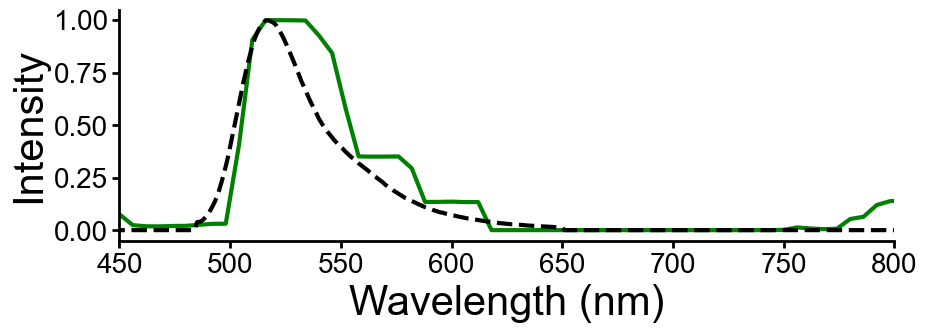

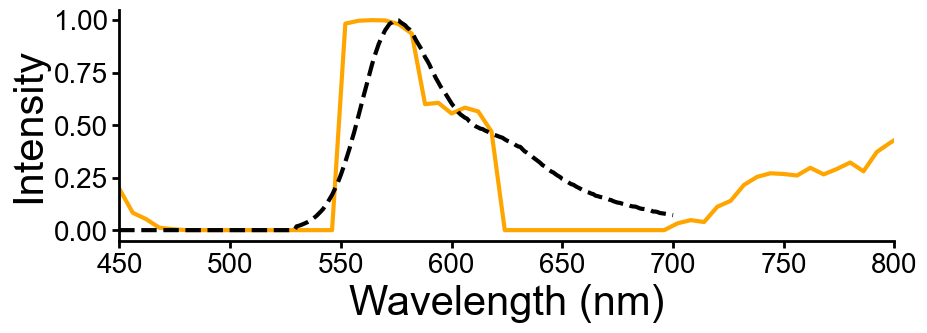

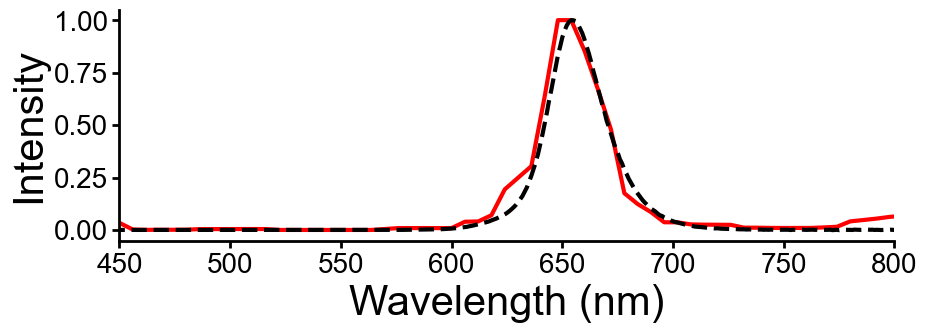

In [42]:
# Define the data folder
datafolder = '/home/emarkley/Workspace/PYTHON/spectraldiffuserscope/recon_materials_organized/cell_dye_spectrum'

# Get the list of CSV files in the directory
csv_files = [f for f in os.listdir(datafolder) if f.endswith('.csv')]

# Initialize an empty list to store the data
combined_data = []

for file in csv_files:
    print(file)
    
    # Read each CSV file into a pandas DataFrame
    file_path = os.path.join(datafolder, file)
    df = pd.read_csv(file_path)
    
    # Normalize the 'Emission' spectrum column
    df['Normalized Emission'] = df['Emission'] / np.max(df['Emission'])
    
    # Add a new row for each file, storing the wavelength and emission arrays
    combined_data.append({
        'Dye': file,
        'Wavelengths': df['Wavelength'].values,
        'Emissions': df['Normalized Emission'].values
    })
    
# Convert the combined data list into a DataFrame
gt_dyes_df = pd.DataFrame(combined_data)

plt.figure(figsize=(10,3))
# plot the spectra for green dye
plt.plot(wavelengths,U[:,1]/np.max(U[:,1]),'g', linewidth=3)
# plot the ground truth spectra dashed
plt.plot(gt_dyes_df['Wavelengths'][0], gt_dyes_df['Emissions'][0], 'k--', linewidth=3)
plt.xlabel('Wavelength (nm)', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([wvmin,wvmax])
# Turn off the top and right edges
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(figure_path,'green_dye.pdf'), format='pdf', dpi=600)
plt.show()

plt.figure(figsize=(10,3))
# plot the spectra for orange dye
plt.plot(wavelengths,U[:,0]/np.max(U[:,0]),'orange', linewidth=3)
# plot the ground truth spectra dashed
plt.plot(gt_dyes_df['Wavelengths'][1], gt_dyes_df['Emissions'][1], 'k--', linewidth=3)
plt.xlabel('Wavelength (nm)', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([wvmin,wvmax])
# Turn off the top and right edges
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(figure_path,'orange_dye.pdf'), format='pdf', dpi=600)
plt.show()

plt.figure(figsize=(10,3))
# plot the spectra for orange dye
plt.plot(wavelengths,U[:,2]/np.max(U[:,2]),'red', linewidth=3)
# plot the ground truth spectra dashed
plt.plot(gt_dyes_df['Wavelengths'][4], gt_dyes_df['Emissions'][4], 'k--', linewidth=3)
plt.xlabel('Wavelength (nm)', fontsize=30)
plt.ylabel('Intensity', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([wvmin,wvmax])
# Turn off the top and right edges
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(os.path.join(figure_path,'red_dye.pdf'), format='pdf', dpi=600)
plt.show()